### Citation
* Kevin Zhang, Kalyan Veeramachaneni, Neha Patki. Sequential Models in the Synthetic Data Vault. Preprint, June 2022.

### Installation

In [2]:
# Restart runtime
!pip install sdv

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.4/126.4 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.8/135.8 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 29.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.5/70.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.3/160.3 kB 16.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.8/79.8 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


### Import

In [64]:
import pandas as pd
import datetime
from datetime import timedelta
from glob import glob
from sdv.metadata import SingleTableMetadata
from sdv.sequential import PARSynthesizer
from sdv.evaluation.single_table import evaluate_quality
from sdv.evaluation.single_table import run_diagnostic
from sdv.evaluation.single_table import get_column_plot

### Data load & preprocessing

In [2]:
# 구글 드라이브 마운트
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# 소프트링크
!ln -s /content/drive/MyDrive/Colab\ Notebooks/DACON/dacon-lettuce-generative /mydrive

In [4]:
# 압축풀기
!mkdir /content/dataset
!cd /mydrive; unzip open.zip -d /content/dataset

Archive:  open.zip
  inflating: /content/dataset/sample_submission.zip  
   creating: /content/dataset/test_input/
  inflating: /content/dataset/test_input/TEST_01.csv  
  inflating: /content/dataset/test_input/TEST_02.csv  
  inflating: /content/dataset/test_input/TEST_03.csv  
  inflating: /content/dataset/test_input/TEST_04.csv  
  inflating: /content/dataset/test_input/TEST_05.csv  
   creating: /content/dataset/test_target/
  inflating: /content/dataset/test_target/TEST_01.csv  
  inflating: /content/dataset/test_target/TEST_02.csv  
  inflating: /content/dataset/test_target/TEST_03.csv  
  inflating: /content/dataset/test_target/TEST_04.csv  
  inflating: /content/dataset/test_target/TEST_05.csv  
   creating: /content/dataset/train_input/
  inflating: /content/dataset/train_input/CASE_01.csv  
  inflating: /content/dataset/train_input/CASE_02.csv  
  inflating: /content/dataset/train_input/CASE_03.csv  
  inflating: /content/dataset/train_input/CASE_04.csv  
  inflating: /conten

In [31]:
# data load & preprocessing
def make_traindata_cpar(input_dir_list):
  train = pd.DataFrame()
  for i in range(len(input_dir_list)):
    train_df = pd.read_csv(input_dir_list[i])
    train_df['Case'] = i + 1
    train = pd.concat([train, train_df])
  train['obs_time'] = pd.to_datetime(train['obs_time'])
  train['new_obs_time'] = train['obs_time'] + train['DAT'].apply(lambda x: timedelta(days=x))

  # 이상값 처리
  # 내부온도,습도=0 -> 평균으로 대체
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부온도관측치'].mean(), 6))
  # print(round(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 4)]['내부습도관측치'].mean(), 6))
  train.loc[train['내부온도관측치'] == 0, '내부온도관측치'] = 28.479124
  train.loc[train['내부습도관측치'] == 0, '내부습도관측치'] = 53.469956

  # 시간당분무량<0 -> 0으로 대체
  train.loc[train['시간당분무량'] < 0, '시간당분무량'] = 0

  # 시간당백색,적색,청색광량<0 -> 최빈값으로 대체
  # print(train_all.loc[train_all['시간당백색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당적색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all.loc[train_all['시간당청색광량'] < 0, ['DAT', 'obs_time', 'Case']])
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당백색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당적색광량'].mode())
  # print(train_all[(train_all['DAT'] == 0) & (train_all['obs_time'] == 15) & (train_all['Case'] != 6)]['시간당청색광량'].mode())
  train.loc[train['시간당백색광량'] < 0, '시간당백색광량'] = 18255.19
  train.loc[train['시간당적색광량'] < 0, '시간당적색광량'] = 0
  train.loc[train['시간당청색광량'] < 0, '시간당청색광량'] = 0

  # 누적, 시간당총광량 column 삭제
  col_names = train.columns
  drop_feature_list = ['DAT', 'obs_time', '시간당총광량']
  for col in col_names:
    if '누적' in col or col in drop_feature_list:
      train = train.drop(col, axis=1)

  train.rename(columns={'new_obs_time':'obs_time'}, inplace=True)
  return train

In [32]:
input_dir_list = sorted(glob('/content/dataset/train_input/*.csv'))
train = make_traindata_cpar(input_dir_list)

In [59]:
input_dir_list1 = ['/content/dataset/train_input/CASE_20.csv']
train_c20 = make_traindata_cpar(input_dir_list1)

### Metadata

In [34]:
metadata = SingleTableMetadata()

In [35]:
metadata.detect_from_dataframe(train)

In [38]:
metadata.update_column(
    column_name='Case',
    sdtype='id',
    regex_format='U_[0-9]{3}')

In [40]:
metadata.set_sequence_key(column_name='Case')
metadata.set_sequence_index(column_name='obs_time')

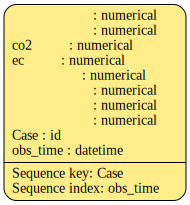

In [42]:
metadata.visualize()

### Create a synthesizer

In [84]:
synthesizer = PARSynthesizer(metadata, epochs=300, verbose=True)
synthesizer.fit(train)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.

Epoch 300 | Loss -8.899800300598145: 100%|██████████| 300/300 [07:59<00:00,  1.60s/it]


In [50]:
synthesizer.save(filepath='/mydrive/model_param/par_synthesizer.pkl')

In [62]:
synthetic_data = synthesizer.sample(num_sequences=28)

In [85]:
synthetic_data

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning:

`should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.



,내부온도관측치,내부습도관측치,co2관측치,ec관측치,시간당분무량,시간당백색광량,시간당적색광량,시간당청색광량,Case,obs_time
0,24.943538,61.909443,528.575079,1.467522,453.966552,6323.887039,0.000000,0.000000,U_025,2023-09-18 00:00:00
1,23.715620,57.484672,512.705680,1.133943,491.326307,844.833274,352.382398,92.164809,U_025,2023-09-18 01:00:00
2,22.944537,56.316677,484.668389,1.507566,0.000000,4671.585275,1279.245050,0.000000,U_025,2023-09-18 02:00:00
3,28.651499,46.318572,461.930756,1.355794,62.269150,0.000000,606.220718,890.648159,U_025,2023-09-18 03:00:00
4,23.017965,47.666190,470.381183,1.331964,853.612792,7107.796660,669.293346,936.770606,U_025,2023-09-18 04:00:00
...,...,...,...,...,...,...,...,...,...,...
18811,31.755353,62.314096,422.917440,0.133566,858.582528,6809.457356,26.431435,0.000000,U_052,2023-10-15 18:59:59
18812,26.591183,63.937932,439.865665,0.122663,799.548263,14692.523051,215.458640,0.000000,U_052,2023-10-15 19:59:59
18813,27.933372,64.158765,454.235361,0.220142,440.331673,11131.607917,189.992640,461.634672,U_052,2023-10-15 20:59:59
18814,29.726351,62.582813,478.297676,0.331803,0.000000,15496.986484,48.037094,432.312802,U_052,2023-10-15 21:59:59


### Evaluation



1. evaluate quality



In [65]:
quality_report = evaluate_quality(real_data=train,
                                  synthetic_data=synthetic_data,
                                  metadata=metadata)

Generating report ...
(2/2) Evaluating Column Pair Trends: : 100%|██████████| 45/45 [00:00<00:00, 61.23it/s]

Overall Quality Score: 85.37%

Properties:
- Column Shapes: 76.75%
- Column Pair Trends: 93.98%


In [66]:
quality_report.get_score()

0.8536577164454198

In [67]:
quality_report.get_properties()

,Property,Score
0,Column Shapes,0.767515
1,Column Pair Trends,0.939801


In [68]:
quality_report.get_details(property_name='Column Shapes')

,Column,Metric,Score
0,내부온도관측치,KSComplement,0.952168
1,내부습도관측치,KSComplement,0.724702
2,co2관측치,KSComplement,0.901945
3,ec관측치,KSComplement,0.924692
4,시간당분무량,KSComplement,0.765147
5,시간당백색광량,KSComplement,0.577115
6,시간당적색광량,KSComplement,0.563669
7,시간당청색광량,KSComplement,0.499150
8,obs_time,KSComplement,0.999043


In [69]:
quality_report.get_visualization(property_name='Column Shapes')

<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen imp

2. run diagnostic

In [70]:
diagnostic_report = run_diagnostic(real_data=train,
                                     synthetic_data=synthetic_data,
                                     metadata=metadata)

Generating report ...
(3/3) Evaluating Synthesis: : 100%|██████████| 1/1 [02:22<00:00, 142.39s/it]

Diagnostic Results:

SUCCESS:
✓ The synthetic data follows over 90% of the min/max boundaries set by the real data
✓ Over 90% of the synthetic rows are not copies of the real data

! The synthetic data is missing more than 10% of the numerical ranges present in the real data


In [71]:
diagnostic_report.get_results()

{'SUCCESS': ['The synthetic data follows over 90% of the min/max boundaries set by the real data',
  'Over 90% of the synthetic rows are not copies of the real data'],
 'WARNING': ['The synthetic data is missing more than 10% of the numerical ranges present in the real data'],
 'DANGER': []}

In [72]:
diagnostic_report.get_properties()

,Property,Score
0,Coverage,0.873501
1,Boundary,1.000000
2,Synthesis,1.000000


In [73]:
diagnostic_report.get_details(property_name='Coverage')

,Column,Metric,Score
0,내부온도관측치,RangeCoverage,0.767017
1,내부습도관측치,RangeCoverage,0.985528
2,co2관측치,RangeCoverage,0.511187
3,ec관측치,RangeCoverage,0.757679
4,시간당분무량,RangeCoverage,0.840093
5,시간당백색광량,RangeCoverage,1.000000
6,시간당적색광량,RangeCoverage,1.000000
7,시간당청색광량,RangeCoverage,1.000000
8,obs_time,RangeCoverage,1.000000


3. visualization

In [75]:
fig = get_column_plot(real_data=train,
                      synthetic_data=synthetic_data,
                      column_name='내부온도관측치',
                      metadata=metadata)

fig.show()

<frozen importlib._bootstrap>:914: ImportWarning:

APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_OpenCVImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:914: ImportWarning:

_AltairImportHook.find_spec() not found; falling back to find_module()



In [81]:
fig = get_column_plot(real_data=train,
                      synthetic_data=synthetic_data,
                      column_name='내부습도관측치',
                      metadata=metadata)

fig.show()

In [82]:
fig = get_column_plot(real_data=train,
                      synthetic_data=synthetic_data,
                      column_name='co2관측치',
                      metadata=metadata)

fig.show()

In [83]:
fig = get_column_plot(real_data=train,
                      synthetic_data=synthetic_data,
                      column_name='ec관측치',
                      metadata=metadata)

fig.show()